# Facebook DeepFace Face Recognition Model

### Based on the study [DeepFace: Closing the Gap to Human-Level Performance in Face Verification](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

#### Pre-trained weights: https://github.com/swghosh/DeepFace by Swarup Ghosh

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import keras
from keras.models import Model, Sequential
from keras.layers import Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing import image

# Model

In [4]:
model = Sequential()
model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
model.add(Flatten(name='F0'))
model.add(Dense(4096, activation='relu', name='F7'))
model.add(Dropout(rate=0.5, name='D0'))
model.add(Dense(8631, activation='softmax', name='F8'))

In [36]:
#model.summary()

# Loading Pre-Trained Weights

You can download the pre-trained weights from the link https://github.com/swghosh/DeepFace/releases

In [6]:
model.load_weights("VGGFace2_DeepFace_weights_val-0.9034.h5")

# DeepFace model

Base model was trained on VGGFace2 dataset by Swarup Ghosh and it has 8631 outputs. 

Herein, F7 layer will be used for feature extraction.

In [12]:
deepface_model = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

In [13]:
deepface_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1_input (InputLayer)        (None, 152, 152, 3)       0         
_________________________________________________________________
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
__________

# OpenCV Face Detection Module

In [14]:
opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]
path = folders[0]
for folder in folders[1:]:
    path = path + "/" + folder

detector_path = path+"/data/haarcascade_frontalface_default.xml"

if os.path.isfile(detector_path) != True:
    raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")
else:
    detector = cv2.CascadeClassifier(detector_path)
    print("haarcascade is oke")

haarcascade is oke


In [33]:
def detectFace(img_path, target_size=(152, 152)):
    
    img = cv2.imread(img_path)
    
    faces = detector.detectMultiScale(img, 1.3, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")
    

# Find Similarity

In [16]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

# Data set

In [29]:
dataset = [
    ['tests/img1.jpg', 'tests/img2.jpg', True]
    , ['tests/img3.jpg', 'tests/img4.jpg', True]
    
    , ['tests/img1.jpg', 'tests/img3.jpg', False]
    , ['tests/img1.jpg', 'tests/img4.jpg' , False]
    , ['tests/img2.jpg', 'tests/img3.jpg', False]
    , ['tests/img2.jpg', 'tests/img4.jpg' , False]
    
    , ['tests/img1.jpg', 'tests/img5.jpg' , False]
    , ['tests/img2.jpg', 'tests/img5.jpg' , False]
]

tests/img1.jpg  and  tests/img2.jpg


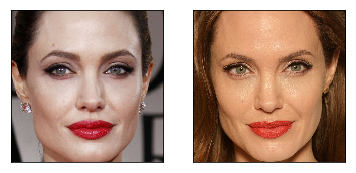

Euclidean L2 distance:  0.48146227
Actual:  True - Predicted:  True
----------------------------------------------
tests/img3.jpg  and  tests/img4.jpg


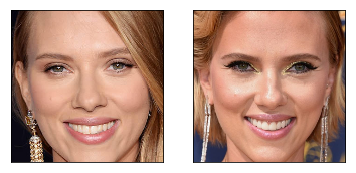

Euclidean L2 distance:  0.53955495
Actual:  True - Predicted:  True
----------------------------------------------
tests/img1.jpg  and  tests/img3.jpg


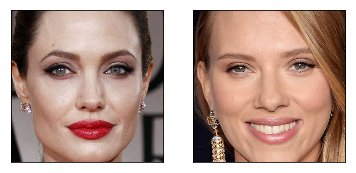

Euclidean L2 distance:  0.60232776
Actual:  False - Predicted:  False
----------------------------------------------
tests/img1.jpg  and  tests/img4.jpg


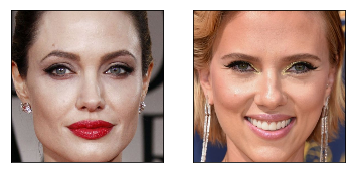

Euclidean L2 distance:  0.5856437
Actual:  False - Predicted:  False
----------------------------------------------
tests/img2.jpg  and  tests/img3.jpg


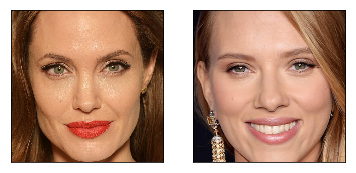

Euclidean L2 distance:  0.655981
Actual:  False - Predicted:  False
----------------------------------------------
tests/img2.jpg  and  tests/img4.jpg


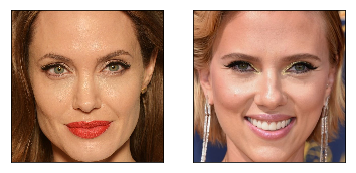

Euclidean L2 distance:  0.6083447
Actual:  False - Predicted:  False
----------------------------------------------
tests/img1.jpg  and  tests/img5.jpg


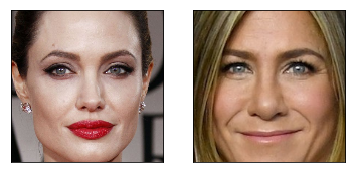

Euclidean L2 distance:  0.63092846
Actual:  False - Predicted:  False
----------------------------------------------
tests/img2.jpg  and  tests/img5.jpg


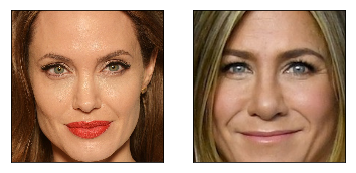

Euclidean L2 distance:  0.64712167
Actual:  False - Predicted:  False
----------------------------------------------


In [35]:
for case in dataset:
    img1_path = case[0]
    img2_path = case[1]
    target = case[2]
    
    print(img1_path, " and ", img2_path)
    
    img1 = detectFace(img1_path)
    img2 = detectFace(img2_path)
    
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(img1[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(1,2, 2)
    plt.imshow(img2[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    #img1_embedding = model.predict(img1)[0] #this has 8631 dimensional output
    #img2_embedding = model.predict(img2)[0] #this has 8631 dimensional output
    img1_embedding = deepface_model.predict(img1)[0] #this has 4096 dimensional output
    img2_embedding = deepface_model.predict(img2)[0] #this has 4096 dimensional output
    
    cosine_distance = findCosineDistance(img1_embedding, img2_embedding)
    cosine_l2_distance = findCosineDistance(l2_normalize(img1_embedding), l2_normalize(img2_embedding))
    euclidean_distance = findEuclideanDistance(img1_embedding, img2_embedding)
    euclidean_l2_distance = findEuclideanDistance(l2_normalize(img1_embedding), l2_normalize(img2_embedding))
    
    #print("Cosine distance: ", cosine_distance)
    #print("Cosine L2 distance: ", cosine_l2_distance)
    #print("Euclidean distance: ", euclidean_distance)
    print("Euclidean L2 distance: ", euclidean_l2_distance)
    print("Actual: ", target, end = '')
    
    #if cosine_distance < 0.16:
    if euclidean_l2_distance <= 0.55:
        verified = True
    else:
        verified = False
        
    print(" - Predicted: ", verified)
    
    print("----------------------------------------------")